In [1]:
import os
from pathlib import Path
import numpy as np
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon
from lib.city_blocks import load_street_graph, remove_deadends, city_blocks
from lib.config import tmp_folder_path
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

%matplotlib inline

In [2]:
def fix_polygon(pol, fixed_pgs):
    if isinstance(pol, MultiPolygon):
        #print('Multipolygon instance')
        for p in pol.geoms:
            clean = p.buffer(0.0)
            if clean.geom_type == 'Polygon':
                if clean.is_valid:
                    p = clean
                    fixed_pgs.append(p)
            elif clean.geom_type == 'MultiPolygon':
                fix_polygon(clean, fixed_pgs)
    else:
        clean = pol.buffer(0.0)
        if clean.geom_type == 'Polygon':
            if clean.is_valid:
                pol = clean
                fixed_pgs.append(pol)
        elif clean.geom_type == 'MultiPolygon':
            fix_polygon(clean, fixed_pgs)

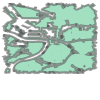

In [3]:
city_gdf = gpd.read_file('geojson/antwerp_grid_blocks.geojson').to_crs({'init': 'epsg:4237'})
city_polygon = city_gdf.geometry.unary_union
city_polygon

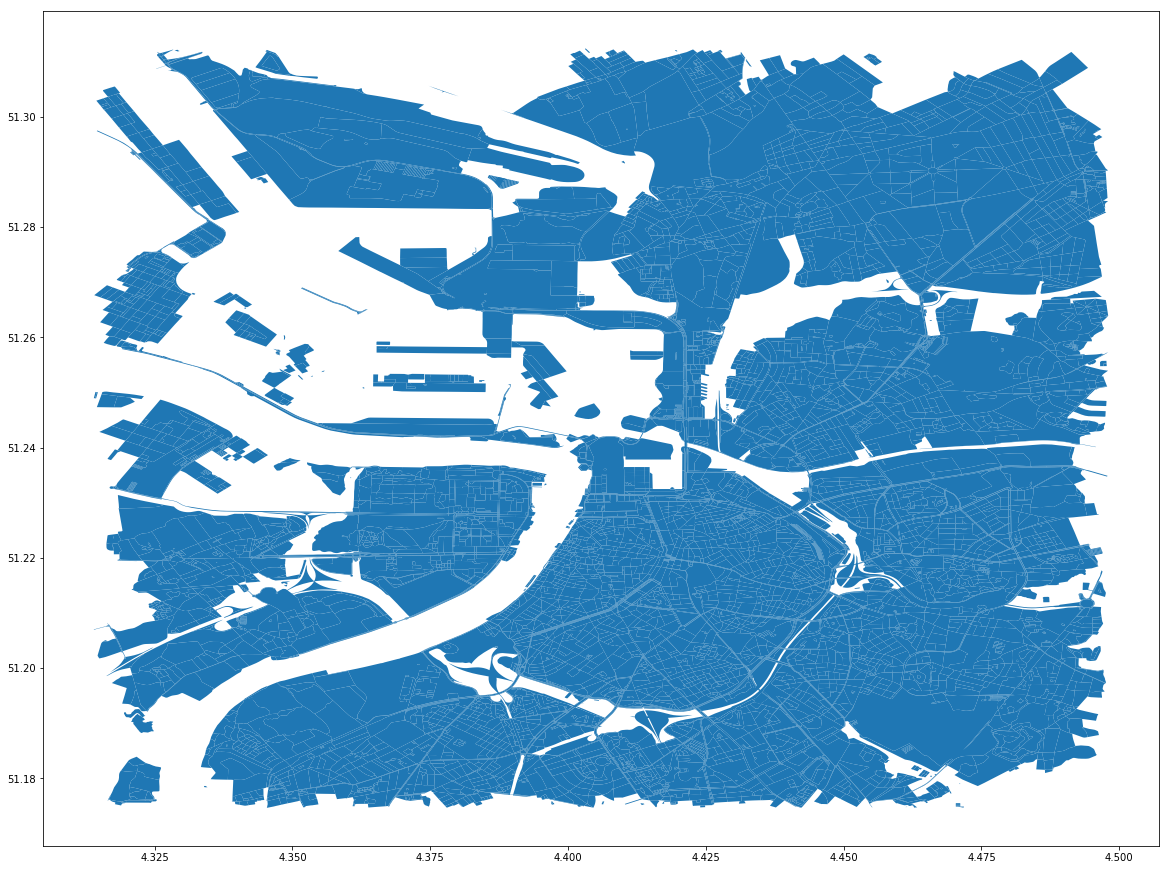

In [4]:
fig, ax = plt.subplots(figsize=(20,20))
city_gdf.plot(ax=ax)

In [5]:
city_gdf.head()

,id,geometry
0,0,"POLYGON ((4.421356311168712 51.20755002836897,..."
1,1,"POLYGON ((4.445842625424431 51.23021450471875,..."
2,2,"POLYGON ((4.405084226585382 51.21782078122615,..."
3,3,"POLYGON ((4.462016118538739 51.27202919757701,..."
4,4,"POLYGON ((4.464777771581316 51.27315907961187,..."


In [14]:
def get_overlaps(gdf):
    data_overlaps=gpd.GeoDataFrame(crs=gdf.crs)
    for index, row in tqdm(gdf.iterrows()):
        data_temp1=gdf.loc[gdf.id!=row.id,]
        # check if intersection occured
        overlaps=data_temp1[data_temp1.geometry.overlaps(row.geometry)]['id'].tolist()
        if len(overlaps)>0:
            temp_list=[]
            # compare the area with threshold
            for i in overlaps:
                temp_area=gpd.overlay(gdf.loc[gdf.id==i,],gdf.loc[gdf.id==row.id,],how='intersection')
                #temp_area=temp_area.loc[temp_area.geometry.area>=9e-9]
                #if temp_area.shape[0]>0:
                data_overlaps=gpd.GeoDataFrame(pd.concat([temp_area,data_overlaps],ignore_index=True),crs=gdf.crs)
    return data_overlaps
    # get unique of list id
    #data_overlaps['sorted']=data_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
    #data_overlaps['sorted']=data_overlaps.sorted.apply(lambda y: ''.join(y))
    #data_overlaps=data_overlaps.drop_duplicates('sorted')
    #data_overlaps=data_overlaps.reset_index()[['id_1','id_2','geometry']]

def remove_overlaps(gdf):
    gdf_copy = gdf.copy()
    for index, row in tqdm(gdf.iterrows()):
        data_temp1=gdf.loc[gdf.id!=row.id,]
        # check if intersection occured
        overlaps=data_temp1[data_temp1.geometry.overlaps(row.geometry)]['id'].tolist()
        if len(overlaps)>0:
            for i in overlaps:
                new_polygon=gpd.overlay(gdf.loc[gdf.id==i,],gdf.loc[gdf.id==row.id,],how='difference')
                gdf_copy = gdf_copy[gdf_copy.id!=i]
                gdf_copy.append(new_polygon, ignore_index=True)                
    return gdf_copy
    # get unique of list id
    #data_overlaps['sorted']=data_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
    #data_overlaps['sorted']=data_overlaps.sorted.apply(lambda y: ''.join(y))
    #data_overlaps=data_overlaps.drop_duplicates('sorted')
    #data_overlaps=data_overlaps.reset_index()[['id_1','id_2','geometry']]

11273it [13:30, 13.91it/s]


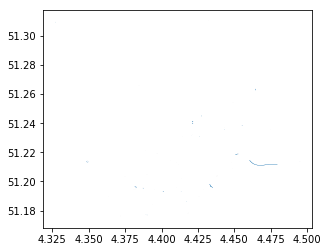

In [8]:
data_overlaps = get_overlaps(city_gdf)
data_overlaps.plot()

In [10]:
data_overlaps.shape

(320, 3)

In [ ]:
city_gdf_no_overlaps = remove_overlaps(city_gdf)

4998it [05:55, 14.12it/s]

In [ ]:
city_gdf_no_overlaps.describe()

In [19]:
bbox_gdf = gpd.read_file('geojson/grid.json').to_crs({'init': 'epsg:4237'})
bbox_polygon = bbox_gdf.geometry.unary_union

#gdf = ox.gdf_from_place(place_name)
buildings = ox.create_footprints_gdf(bbox_polygon, retain_invalid=True)
landuse = ox.create_footprints_gdf(bbox_polygon, retain_invalid=True, footprint_type='landuse')
street_graph = ox.graph_from_polygon(bbox_polygon, simplify=False)
nodes, edges = ox.graph_to_gdfs(street_graph)

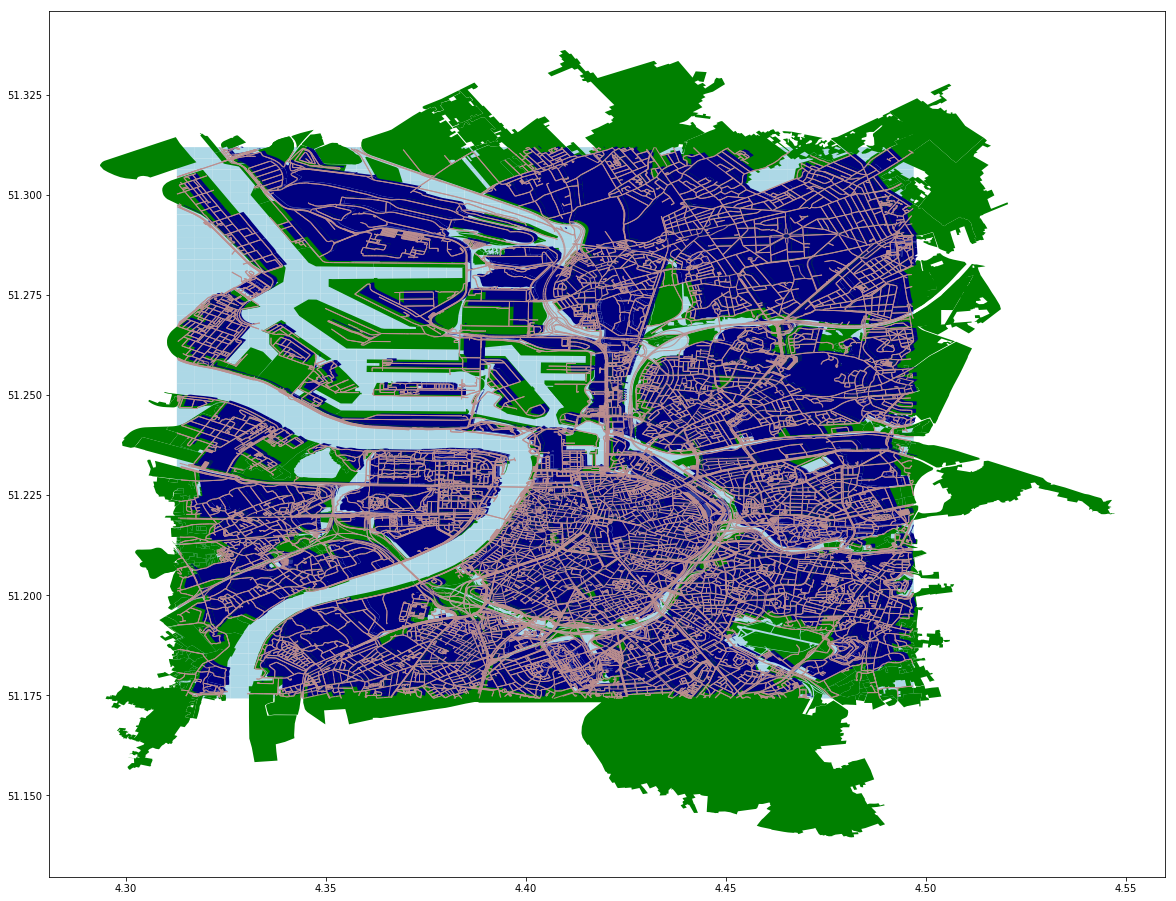

In [20]:
fig0, ax0 = plt.subplots(figsize=(20,20))
bbox_gdf.plot(ax=ax0, facecolor='#add8e6')
edges.plot(ax=ax0, linewidth=1, edgecolor='#BC8F8F')
#area.plot(ax=ax0, facecolor='#000080')
landuse.plot(ax=ax0, facecolor='#008000')
city_gdf_no_overlaps.plot(ax=ax0, facecolor='#000080')

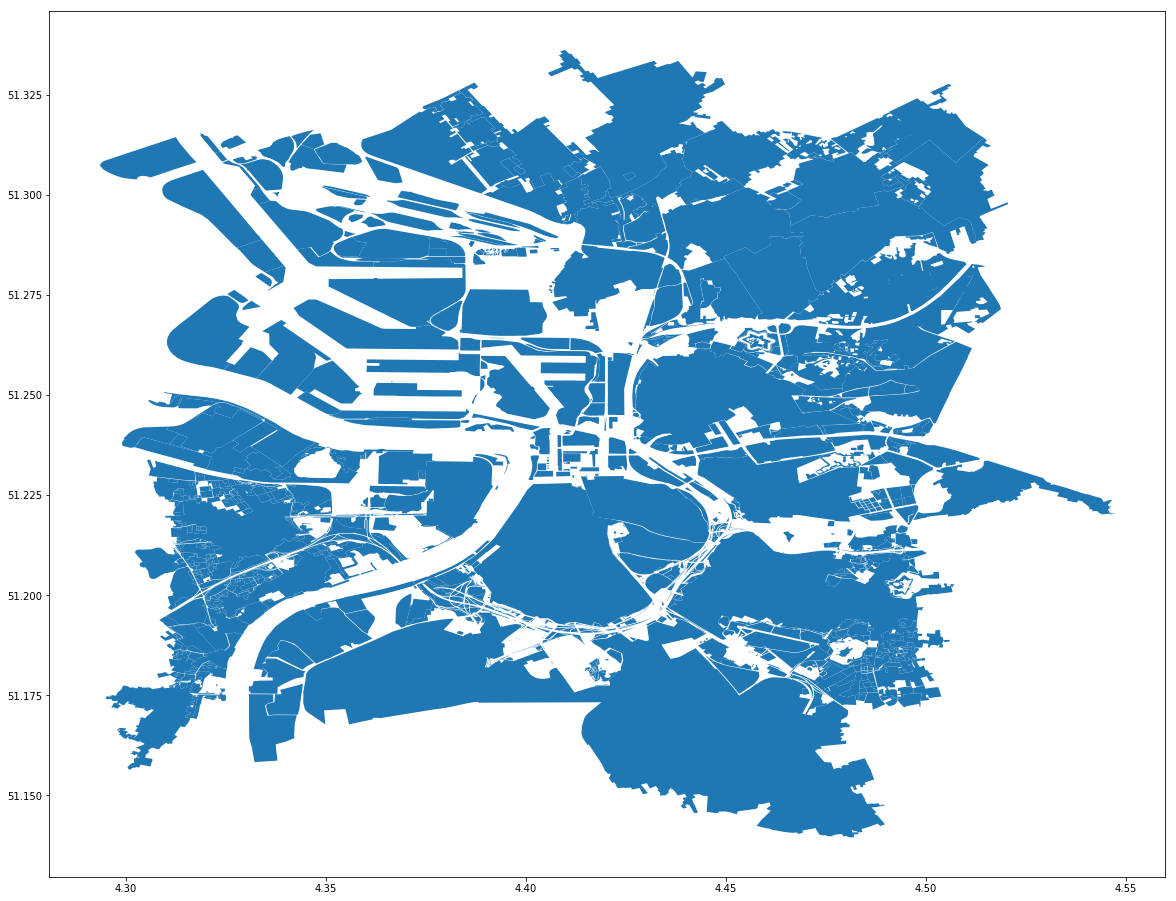

In [18]:
fig1, ax1 = plt.subplots(figsize=(20,20))
landuse.plot(ax=ax1)

In [21]:
diff_city_gdf = gpd.overlay(landuse.to_crs({'init': 'epsg:4237'}), city_gdf_no_overlaps.to_crs({'init': 'epsg:4237'}), how='difference')

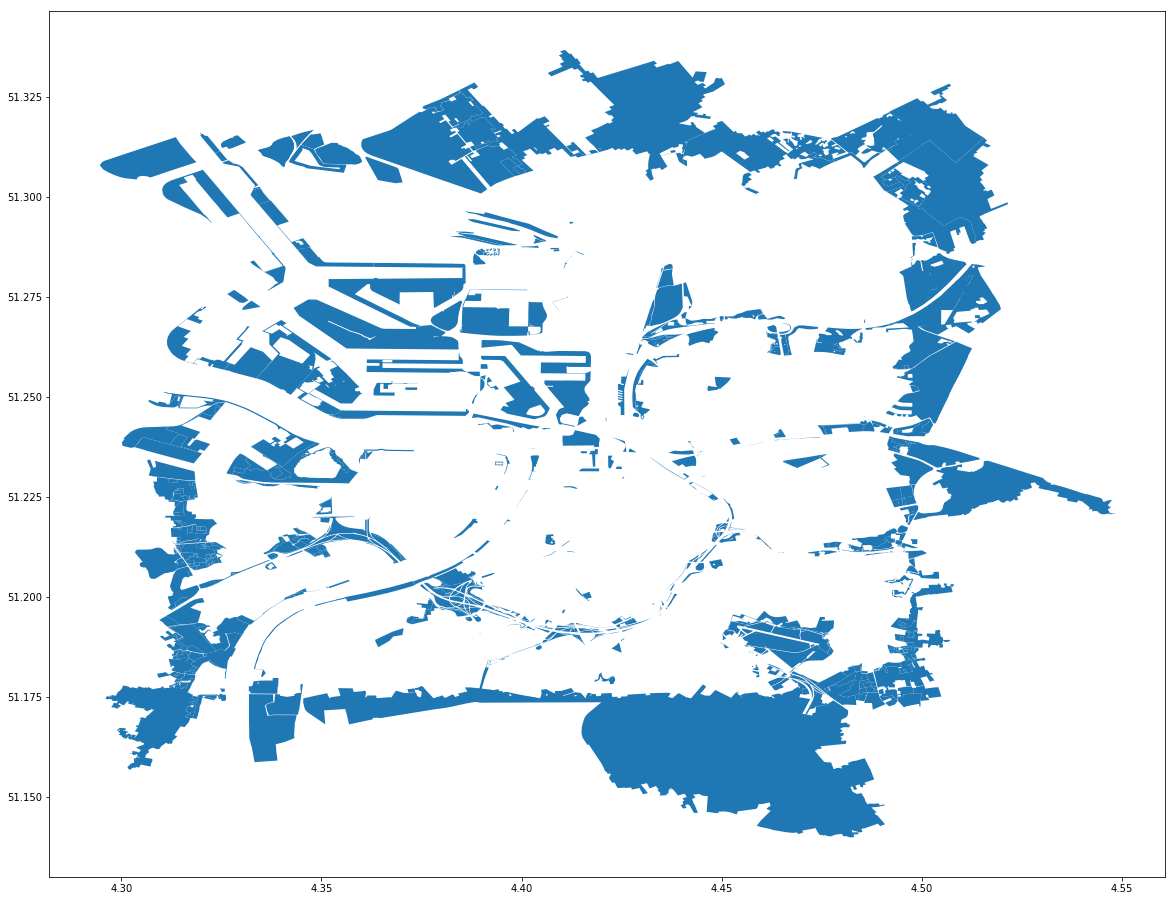

In [22]:
fig2, ax2 = plt.subplots(figsize=(20,20))
diff_city_gdf.plot(ax=ax2)

In [23]:
new_city_gdf = gpd.overlay(diff_city_gdf.to_crs({'init': 'epsg:4237'}), city_gdf_no_overlaps.to_crs({'init': 'epsg:4237'}), how='union')

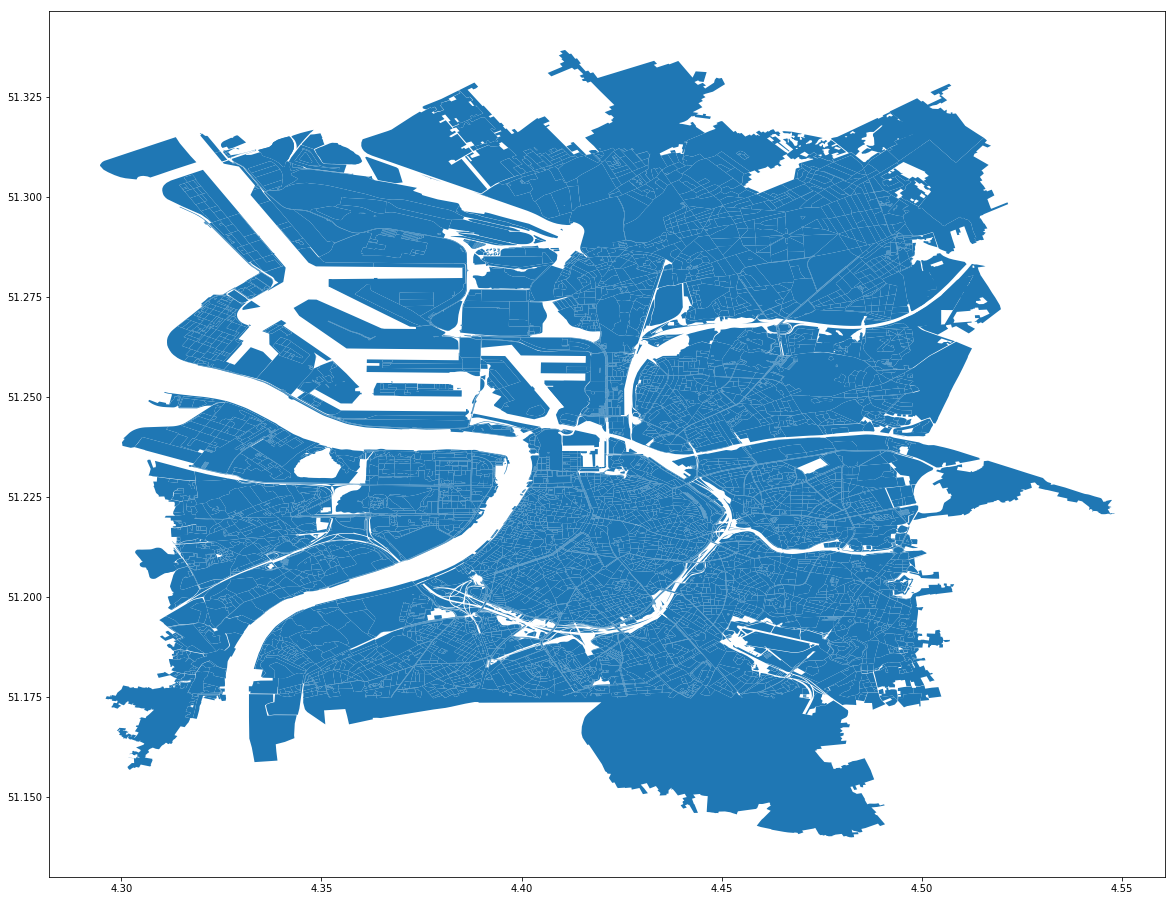

In [24]:
fig3, ax3 = plt.subplots(figsize=(20,20))
new_city_gdf.plot(ax=ax3)

In [28]:
assert new_city_gdf[new_city_gdf.is_valid == False].shape[0] == 0

## Save areas as GeoJson

In [ ]:
filename = 'antwerp_sq_grid_blocks'
geofile = Path(tmp_folder_path, filename).with_suffix('.geojson')

with open(geofile, 'w+') as af: 
    af.write(new_city_gdf.geometry.to_json())